VAE based on the paper Deep Dynamical Modeling and Control of Unstead Fluid Flows: https://arxiv.org/pdf/1805.07472.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import torch 
import torch.nn as nn

In [2]:
def lorenz(t, x): # x is coordinates (x,y,z)
    return np.array([10*(x[1]-x[0]), x[0]*(28-x[2]) - x[1], x[0]*x[1] - 2.667*x[2]])

In [41]:
lorenz_attractor = integrate.solve_ivp(lorenz, (0.01,40), np.array([1.0, 0.0, 0.0]), max_step=0.01)
trajectory = torch.tensor(np.transpose(lorenz_attractor['y']), dtype=torch.float)
trajectory.shape

torch.Size([4003, 3])

In [43]:
x_traj = trajectory[:, 0]
y_traj = trajectory[:, 1]
z_traj = trajectory[:, 2]

D:\Programs\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


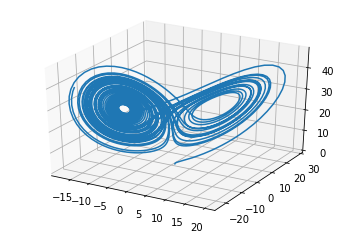

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_traj, y_traj, z_traj)

In [ ]:
'''
x = trajectory[0:n]    # (3, n)
y = trajectory[1:n+1]  # (3, n)

# encoding

x_ = g(x)
y_ = g(y)

A = y_ * moore_penrose_inverse(x_)

loss = (y_ - A * x_) ** 2

y_pred = A * x_

# decoding

X = decoder(x_)   # decoder is inverse of g


Y = decoder(y_pred)

loss = (x - X)**2 + (y - Y)**2
'''

In [79]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.enc1 = nn.Linear(3, 5)
        self.enc2 = nn.Linear(5, 2)
        
        self.dec1 = nn.Linear(2, 5)
        self.dec2 = nn.Linear(5, 3)
        
    def encode(self, x):
        x = torch.tanh(self.enc1(x))
        return self.enc2(x)
    
    def decode(self, x):
        x = torch.tanh(self.dec1(x))
        return self.dec2(x)
        
    def forward(self, traj):  # (num_steps, state)
        # split trajectory into "shifted" versions
        n = traj.shape[0]
        x = traj[:n-1]
        y = traj[1:n]
        
        # transpose so that A comes out with the right shape
        x_ = torch.transpose(self.encode(x), 0, 1)  # (reduced_state, num_steps-1)
        y_ = torch.transpose(self.encode(y), 0, 1)
        
        # calculate A with the Moore-Penrose inverse
        A = torch.matmul(y_, torch.pinverse(x_))  # (reduced_state, reduced_state)
        
        x_0 = x_.narrow(1, 0, 1)  # (reduced_state, 1)
        y_pred = torch.matmul(A, x_0)  # (reduced_state, 1) 
        
        # recursively multiply x_0 by A to predict y_
        for i in range(n-2):
            y_pred_n = torch.matmul(A, y_pred.narrow(1, i, 1))
            y_pred = torch.cat((y_pred, y_pred_n), 1)
            
        # y_pred should have shape (reduced_state, num_steps-1)
            
        # un-transpose and decode
        x_ = torch.transpose(x_, 0, 1)  # (num_steps-1, reduced_state)
        y_pred = torch.transpose(y_pred, 0, 1)
        
        X = self.decode(x_)  # (num_steps-1, full_state)
        Y = self.decode(y_pred)
        
        return X, Y

In [83]:
autoencoder = VAE()

In [82]:
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.002)
loss = nn.MSELoss()

n = trajectory.shape[0]
x = trajectory[:n-1]
y = trajectory[1:n]

for i in range(800):
    optim.zero_grad()
    
    X, Y = autoencoder(trajectory)
    
    l = loss(x, X) + loss(y, Y)
    l.backward()
    optim.step()
    
    print(l)

tensor(468.7211, grad_fn=<AddBackward0>)
tensor(468.1979, grad_fn=<AddBackward0>)
tensor(467.6788, grad_fn=<AddBackward0>)
tensor(467.1601, grad_fn=<AddBackward0>)
tensor(466.6388, grad_fn=<AddBackward0>)
tensor(466.1193, grad_fn=<AddBackward0>)
tensor(465.6019, grad_fn=<AddBackward0>)
tensor(465.0929, grad_fn=<AddBackward0>)
tensor(464.5817, grad_fn=<AddBackward0>)
tensor(464.0709, grad_fn=<AddBackward0>)
tensor(463.5638, grad_fn=<AddBackward0>)
tensor(463.0580, grad_fn=<AddBackward0>)
tensor(462.5587, grad_fn=<AddBackward0>)
tensor(462.0580, grad_fn=<AddBackward0>)
tensor(461.5620, grad_fn=<AddBackward0>)
tensor(461.0648, grad_fn=<AddBackward0>)
tensor(460.5737, grad_fn=<AddBackward0>)
tensor(460.0745, grad_fn=<AddBackward0>)
tensor(459.5902, grad_fn=<AddBackward0>)
tensor(459.1050, grad_fn=<AddBackward0>)
tensor(458.6183, grad_fn=<AddBackward0>)
tensor(458.1356, grad_fn=<AddBackward0>)
tensor(457.6517, grad_fn=<AddBackward0>)
tensor(457.1666, grad_fn=<AddBackward0>)
tensor(456.6831,

tensor(385.5057, grad_fn=<AddBackward0>)
tensor(385.1789, grad_fn=<AddBackward0>)
tensor(384.8516, grad_fn=<AddBackward0>)
tensor(384.5243, grad_fn=<AddBackward0>)
tensor(384.1977, grad_fn=<AddBackward0>)
tensor(383.8729, grad_fn=<AddBackward0>)
tensor(383.5482, grad_fn=<AddBackward0>)
tensor(383.2231, grad_fn=<AddBackward0>)
tensor(382.8995, grad_fn=<AddBackward0>)
tensor(382.5758, grad_fn=<AddBackward0>)
tensor(382.2531, grad_fn=<AddBackward0>)
tensor(381.9305, grad_fn=<AddBackward0>)
tensor(381.6085, grad_fn=<AddBackward0>)
tensor(381.2878, grad_fn=<AddBackward0>)
tensor(380.9681, grad_fn=<AddBackward0>)
tensor(380.6462, grad_fn=<AddBackward0>)
tensor(380.3276, grad_fn=<AddBackward0>)
tensor(380.0089, grad_fn=<AddBackward0>)
tensor(379.6918, grad_fn=<AddBackward0>)
tensor(379.3725, grad_fn=<AddBackward0>)
tensor(379.0538, grad_fn=<AddBackward0>)
tensor(378.7380, grad_fn=<AddBackward0>)
tensor(378.4210, grad_fn=<AddBackward0>)
tensor(378.1052, grad_fn=<AddBackward0>)
tensor(377.7909,

tensor(327.7384, grad_fn=<AddBackward0>)
tensor(327.4780, grad_fn=<AddBackward0>)
tensor(327.2165, grad_fn=<AddBackward0>)
tensor(326.9557, grad_fn=<AddBackward0>)
tensor(326.6954, grad_fn=<AddBackward0>)
tensor(326.4343, grad_fn=<AddBackward0>)
tensor(326.1743, grad_fn=<AddBackward0>)
tensor(325.9144, grad_fn=<AddBackward0>)
tensor(325.6544, grad_fn=<AddBackward0>)
tensor(325.3950, grad_fn=<AddBackward0>)
tensor(325.1349, grad_fn=<AddBackward0>)
tensor(324.8760, grad_fn=<AddBackward0>)
tensor(324.6169, grad_fn=<AddBackward0>)
tensor(324.3588, grad_fn=<AddBackward0>)
tensor(324.0995, grad_fn=<AddBackward0>)
tensor(323.8414, grad_fn=<AddBackward0>)
tensor(323.5834, grad_fn=<AddBackward0>)
tensor(323.3252, grad_fn=<AddBackward0>)
tensor(323.0677, grad_fn=<AddBackward0>)
tensor(322.8097, grad_fn=<AddBackward0>)
tensor(322.5529, grad_fn=<AddBackward0>)
tensor(322.2958, grad_fn=<AddBackward0>)
tensor(322.0385, grad_fn=<AddBackward0>)
tensor(321.7825, grad_fn=<AddBackward0>)
tensor(321.5258,

tensor(279.6067, grad_fn=<AddBackward0>)
tensor(279.3860, grad_fn=<AddBackward0>)
tensor(279.1652, grad_fn=<AddBackward0>)
tensor(278.9453, grad_fn=<AddBackward0>)
tensor(278.7247, grad_fn=<AddBackward0>)
tensor(278.5049, grad_fn=<AddBackward0>)
tensor(278.2855, grad_fn=<AddBackward0>)
tensor(278.0653, grad_fn=<AddBackward0>)
tensor(277.8458, grad_fn=<AddBackward0>)
tensor(277.6268, grad_fn=<AddBackward0>)
tensor(277.4080, grad_fn=<AddBackward0>)
tensor(277.1891, grad_fn=<AddBackward0>)
tensor(276.9702, grad_fn=<AddBackward0>)
tensor(276.7513, grad_fn=<AddBackward0>)
tensor(276.5334, grad_fn=<AddBackward0>)
tensor(276.3151, grad_fn=<AddBackward0>)
tensor(276.0972, grad_fn=<AddBackward0>)
tensor(275.8793, grad_fn=<AddBackward0>)
tensor(275.6616, grad_fn=<AddBackward0>)
tensor(275.4442, grad_fn=<AddBackward0>)
tensor(275.2276, grad_fn=<AddBackward0>)
tensor(275.0101, grad_fn=<AddBackward0>)
tensor(274.7934, grad_fn=<AddBackward0>)
tensor(274.5767, grad_fn=<AddBackward0>)
tensor(274.3599,